In [1]:
import sys

sys.path.append("..")

import os 
from create_dataset import CreateSegmentationDataset, get_labels_dict
from segment.utils import get_device
from datasets import load_dataset

# disable datasets.map progress bar
from datasets.utils.logging import disable_progress_bar
disable_progress_bar()

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
# Set the cache dir
cache_dir = "hf_cache"

# Torch Settings
batch_size = 8
num_workers = os.cpu_count()
device = get_device()

# Get the labels from the yolo config file
config_path = "configs/fashion_people_detection_no_person.yml"

# Get the labels from the config file
labels_dict = get_labels_dict(config_path)
labels = [k for k, v in labels_dict.items()]
text_prompt = " . ".join(labels)
print(f"Labels To Use: {text_prompt}")

# Enter the dataset ID and load it as a torch dataset
dataset_id = "MnLgt/fashion_people_detections"
split = "train[:100]"

# Enter the repo name to push the new dataset to
new_repo_id = "MnLgt/fashion_people_detections_new"

Labels To Use: hair . face . neck . arm . hand . back . leg . foot . outfit . phone . hat . shoe


In [3]:
ds = load_dataset(
    dataset_id,
    split=split,
    trust_remote_code=True,
    cache_dir="hf_cache",
    streaming=False,
    num_proc=num_workers
)

In [19]:
p = CreateSegmentationDataset(ds, config_path, bs=512, text_threshold=0.35)

In [20]:
p.process()

  0%|          | 0/1 [00:00<?, ?it/s]

Processing Images:   0%|          | 0/100 [00:00<?, ?img/s]

One Image had an error: 'float' object is not iterable


In [21]:
from create_dataset import filter_list_in_column

def remove_none(item):
    return bool(item)

p.processed_ds = filter_list_in_column(p.processed_ds, 'metadata', remove_none)

Image URL: https://i.pinimg.com/originals/81/5b/45/815b45344ea3b90b22a6bd5af468024d.webp
Label: shoe
Score: 0.9044515490531921


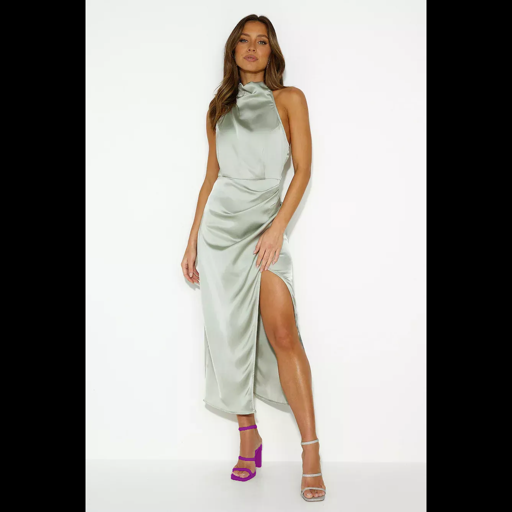

In [248]:
p.check_results()